In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import csv
from scipy.optimize import curve_fit
import time
from scipy.signal import argrelextrema

#bose einstein distribution
#constants
k = 1.3806504e-23
hb = 1.0545716e-34
h = (2.0*math.pi*1.0545716e-34) 
c = 2.9979246e+8

#mu
def defMu(u, numTotal, omega1, t):
    muD = -1e-18
    muT = -1e-36
    numLim = 2 * numTotal + 1
    while(abs(numLim - numTotal) > 1e-4):
        muM = -math.sqrt(muD * muT)
        numLim = distrib(t, muM, u, omega1).sum()
        if(numLim < numTotal):
            muD = muM
        else:
            muT = muM
    #print('chem pot', muM)
    #print('mu/kt', muM / k / t)
    
    return muM
#energy distribution
def distrib(t, mu, u, omega1):
    fg = np.vectorize(lambda x: 2 * float(x / (hb * omega1) + 1))
    g = fg(u)
    f = np.vectorize(lambda x: 1 /(np.exp(float(x - mu)/float(k*t)) - 1))
    num1 = f(u)
    num = g * num1
    return num
#get spec
def getSpec(numTotal = 10000, modesNum = 1000,Lc = 585e-9,
            n = 1.4, q = 7 ,R = 1.0, t = 300, modesNumForMu = 2000):
    D0 = q * Lc / (n * 2) 
    omega1 = c / (n * math.sqrt(D0 * R / 2))
    #modes of oscilator
    u = np.arange(0, modesNum * hb * omega1, hb * omega1)
    uForMu = np.arange(0, modesNumForMu * hb * omega1, hb * omega1)
    E_tmp = u + h*c/Lc
    waveL = h*c/E_tmp
    mu = defMu(uForMu, numTotal, omega1, t)
    num = distrib(t, mu, u, omega1)
    
    n0 = 1/(np.exp(float(-mu)/k/t)-1) #photons in the condensate
    print('photons in the ground mode', n0)
    print('chemical potential', mu)
    return num, waveL

def readSpec(specName, delimiter):
    x = np.array([])
    y = np.array([])
    with open(specName, newline='') as f:
        fr = csv.reader(f, delimiter=delimiter, quotechar='|')
        for row in fr:
            if row != []:
                y = np.append(y, row[0])
                x = np.append(x, row[1])
                #print(y, x)
    x = x.astype(np.float64)
    y = y.astype(np.float64)
    return y, x

def func(x, a, b, c, d, e, f):
     return a + b * x + c * x ** 2 + d * x ** 3 + e * x ** 4 + f * x ** 5 
    
def transM(y, x):
    tx, ty = readSpec('transmission_losgatos.dat', ' ')
    f = np.vectorize(lambda zz: min(tx, key=lambda z:abs(z-zz)))
    x1 = f(x)
    f = np.vectorize(lambda z: np.where(tx == z)[0][0])
    ind = f(x1)
    f = np.vectorize(lambda z: ty[z])
    y1 = f(ind)
    y11 = y / y1
    y = y11 / max(y11)
        
    #xmin = min(np.where(tx >= min(x))[0])
    #xmax = max(np.where(tx <= max(x))[0])
    #tx1 = tx[xmin:xmax]
    #ty1 = ty[xmin:xmax]
    #popt, pcov = curve_fit(func, tx1, 1/ty1)
    #y1 = func(x,*popt)
    #y1 = (y1 > 0) * y1
    #y = y * y1
    #y = y / y.max()
    
    return y,x
    
def plotSpec1(specName,lg, trans = True):
    folder = ''
    specName = folder + specName
    y, x = readSpec(specName, ',')
    
    if trans:
        pass
        #y, x =transM(y, x)
    
    if lg:
        f = np.vectorize(lambda x: math.log(x))
        np.place(y, y == 0, 1)
        y = f(y) / max(abs(f(y))) + max(y)
    return x,y 

def convolution(num, wl, cWidth = 300):
    convNum = np.arange(-50, 51, 1)
    addZ = 500
    numC = np.zeros(len(num) + addZ * 2)
    num = np.append(np.zeros(addZ) , np.append(num, np.zeros(addZ)))
    
    wlStep = abs(wl[-1] - wl[-2])
    wlC1 = np.arange(min(wl), min(wl) - wlStep * addZ,-wlStep)
    
    wlStep = abs(wl[1] - wl[0])
    wlC2 = np.arange(max(wl) + wlStep * addZ, max(wl),-wlStep)
    
    wlC = np.append(wlC2, np.append(wl, wlC1))
    
    ii = -1
    
    for wl1 in wlC:
        ii += 1
        for jj in convNum:
            if jj + ii > 0 and jj + ii < len(numC):
                numC[ii + jj] += num[ii] * np.sqrt(1/ (np.pi * cWidth)) * np.exp(-jj ** 2 / cWidth)
    return numC, wlC

ii = 268
def binning(xIn, yIn, num = 20):
    while yIn.size%num != 0:
        yIn = yIn[1:]
        xIn = xIn[1:]
    yOut = np.mean(yIn.reshape(-1, num), axis=1)
    xOut = np.mean(xIn.reshape(-1, num), axis=1)
    error = np.std(yIn.reshape(-1, num), axis=1)
    return xOut, yOut, error

def readSp(specName, delimiter):
    x = np.array([])
    y = np.array([])
    with open(specName, newline='') as f:
        fr = csv.reader(f, delimiter=delimiter, quotechar='|')
        ii = 0
        for row in fr:
            ii += 1
            if ii > 33 and ii < 3682:
                y = np.append(y, row[1])
                x = np.append(x, row[0])
                #print(y, x)
    x = x.astype(np.float)
    y = y.astype(np.float)
    out = np.array([[1,1]])
    ii = -1
    for _ in x:
        ii += 1
        out = np.append(out, [[x[ii],y[ii]]], axis = 0)
    out = out[1:]
    return out

photon num 105450
max at wl 570.855590630701
photons in the ground mode 12460.792636236487
chemical potential -3.3238535705216147e-25
570.8117382562136


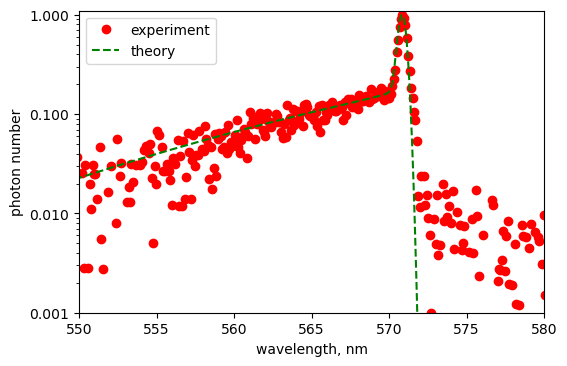

In [18]:
def run():
    #     dd = np.genfromtxt('data/64.txt', delimiter = ' ')
#     x = dd[:, 1]
#     y = dd[:, 2]    
    #dd = np.genfromtxt('data/0110450.spc', delimiter = ' ')
    #x = dd[:,0]
    #y = dd[:,1]
    
    specName = 'data/spec6.csv'
    y,x = readSpec(specName, ',')

    fig, ax = plt.subplots(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')

    #y = y/max(y)
    x, y, err = binning(x, y, num = 1)
    y = y/max(y)

    ax.semilogy(x, y, linestyle='', marker='o', color='red')#, label='Rcm')

    phNum = 105450
    Lc = 572.5e-9
    Lc = x[np.where(y == max(y))[0][0]]*1e-9
    print('photon num', phNum)
    print('max at wl',x[np.where(y == max(y))[0][0]])
        
    num, wavel = getSpec(phNum, 1000, t = 300, Lc = Lc, q = 7, R = 1)
    num, wavel = convolution(num, wavel, 70)

    ax.plot(wavel[:] * 1e9, num[:]/num[:].max(),linestyle='--', marker='', color='green')#, label='Rcm')  
    numGrad = np.gradient(np.gradient(num))
    print(wavel[np.argmax(num)] * 1e9)
        
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # 2 decimal places
    plt.xlabel('wavelength, nm')
    plt.ylabel('photon number')
    plt.ylim(0.001, 1.1)
    plt.xlim(550, 580)
    plt.legend(('experiment','theory'))
    plt.show()
    
run()

FileNotFoundError: [Errno 2] No such file or directory: 'spec3.csv'

In [ ]:
1/(np.exp(float(-mu)/k/t)-1) 